# 1. Test async model

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

# LLMs y mensajes de LangChain
from langchain_openai import ChatOpenAI
from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

# Herramienta Tavily (búsqueda)
from langchain_community.tools.tavily_search import TavilySearchResults

# LangGraph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# Para visualizar el grafo en un notebook (opcional)
from IPython.display import Image, display

In [2]:
# =====================================================================
# 2) DEFINIR ESTADO
# =====================================================================
class ChatState(TypedDict):
    """
    - messages: historial (HumanMessage, AIMessage, etc.)
    - topic_decision: 'yes'/'no' indica si la última pregunta
      se considera 'respondible' en el contexto la transparencia gubernamental
    """
    messages: Annotated[list, add_messages]
    topic_decision: str


# =====================================================================
# 3) CREAR EL StateGraph BUILDER
# =====================================================================
graph_builder = StateGraph(ChatState)


# =====================================================================
# 4) DEFINIR LOS DOS MODELOS
#    - llm_classifier (temperature=0) para la clasificación
#    - llm_main (chat principal, con system_message)
# =====================================================================
llm_classifier = ChatOpenAI(
    model="gpt-4o-mini",  # ejemplificativo
    temperature=0.0,
    timeout=30
)

llm_fallback = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.7,
    timeout=30
)

llm_main = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.7,
    timeout=30
)

# Mensaje de sistema para el nodo principal
system_prompt = (
    "Eres un asistente conversacional especializado en temas de transparencia gubernamental del Estado peruano. "
    "Respondes de forma clara, respetuosa y profesional, utilizando fuentes confiables cuando es necesario. "
    "Puedes ayudar con información sobre contrataciones públicas, empresas proveedoras del Estado, "
    "asistencia y votaciones del Congreso entre los años 2006 y 2024. "
    "Tu objetivo es facilitar el acceso a datos públicos relevantes para la ciudadanía."
)
system_message = SystemMessage(content=system_prompt)

# Mensaje de sistema para el nodo fallback
fallback_prompt = (
        "Eres un asistente cordial y profesional. Aunque no puedes responder preguntas "
        "fuera del dominio de transparencia gubernamental del Estado peruano, debes explicar "
        "educadamente cuál es tu función y sugerir temas válidos, como contrataciones públicas o votaciones del Congreso. "
        "Si el usuario simplemente saluda, responde con cortesía e invita a hacer una consulta sobre esos temas."
    )
fallback_system_message = SystemMessage(content=fallback_prompt)


# =====================================================================
# 5) HERRAMIENTA TAVILY
# =====================================================================
tavily_tool = TavilySearchResults(max_results=2)
tools = [tavily_tool]

# Decirle al llm_main que conoce y puede usar la herramienta
llm_with_tools = llm_main.bind_tools(tools)

In [3]:
# =====================================================================
# 6) NODOS
# =====================================================================
def topic_classifier_node(state: ChatState):
    """
    Analiza todo el historial y decide si la última pregunta del usuario
    se puede responder en el contexto de transparencia gubernamental.

    Devuelve {"topic_decision": "yes"} o {"topic_decision": "no"}.
    """
    if not state["messages"]:
        return {"topic_decision": "no"}

    conversation_text = ""
    for msg in state["messages"]:
        if isinstance(msg, HumanMessage):
            conversation_text += f"Usuario: {msg.content}\n"
        elif isinstance(msg, AIMessage):
            conversation_text += f"Asistente: {msg.content}\n"

    classification_prompt = f"""
Eres un verificador que decide si la última pregunta del usuario puede
ser respondida en el contexto de transparencia gubernamental del Estado
peruano, considerando toda la conversación previa.

- Si la conversación está relacionada con contrataciones públicas, 
  empresas proveedoras del Estado, o actividad parlamentaria (asistencia,
  votaciones, licencias), responde 'yes'.
- Si no está relacionada con eso, responde 'no'.

Responde únicamente con 'yes' o 'no'.

--- CONVERSACIÓN ---
{conversation_text}
--- FIN ---
¿Se puede responder esta última pregunta dentro del contexto de transparencia gubernamental?
"""

    decision_msg = llm_classifier.invoke([HumanMessage(content=classification_prompt)])
    decision_str = decision_msg.content.strip().lower()

    if decision_str.startswith("y"):
        return {"topic_decision": "yes"}
    else:
        return {"topic_decision": "no"}


def route_topic(state: ChatState) -> str:
    """
    Lee state["topic_decision"] y retorna 'chatbot' o 'fallback'.
    """
    return "chatbot" if state.get("topic_decision", "no").startswith("y") else "fallback"


def chatbot_node(state: ChatState):
    """
    Nodo principal:
    - Usa todo el historial + system_message
    - Invoca llm_with_tools (con acceso a herramientas como búsqueda o consultas estructuradas).
    """
    messages = [system_message] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def fallback_node(state: ChatState):
    """
    Usa un modelo especializado para responder amablemente cuando la consulta
    está fuera de dominio. Informa al usuario sobre el propósito del asistente.
    """
    messages = [fallback_system_message] + state["messages"]
    response = llm_fallback.invoke(messages)
    return {"messages": [response]}

tool_node = ToolNode(tools=tools)

In [4]:
# =====================================================================
# 7) AÑADIR AL BUILDER
# =====================================================================
graph_builder.add_node("topic_classifier", topic_classifier_node)
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_node("fallback", fallback_node)
graph_builder.add_node("tools", tool_node)

In [5]:
# =====================================================================
# 8) CONECTAR NODOS
# =====================================================================
# - START -> topic_classifier
graph_builder.add_edge(START, "topic_classifier")

# - topic_classifier -> route_topic -> (chatbot | fallback)
graph_builder.add_conditional_edges(
    "topic_classifier",
    route_topic,
    {"chatbot": "chatbot", "fallback": "fallback"},
)

# - chatbot -> tools_condition -> (tools o END)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")

# - fallback -> END
graph_builder.add_edge("fallback", END)


In [6]:
# =====================================================================
# 9) COMPILAR CON MemorySaver (almacena historial)
# =====================================================================
memory_saver = MemorySaver()
graph = graph_builder.compile(checkpointer=memory_saver)


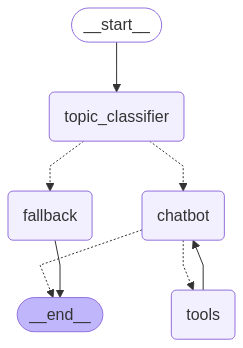

In [7]:
# =====================================================================
# 10) VISUALIZAR GRAFO (EN NOTEBOOK, OPCIONAL)
# =====================================================================
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    print(graph.get_graph().draw_ascii())

In [11]:
# =====================================================================
# 11) FUNCIÓN DE BUCLE DE CONVERSACIÓN
# =====================================================================
def run_chatbot():
    """
    Loop interactivo. 
    Se detiene con 'salir', 'exit', 'quit'.
    Usamos 'rappi-classifier-demo' como thread_id.
    """
    config = {"configurable": {"thread_id": "rappi-classifier-demo"}}

    print("¡Bienvenido al Chatbot de RappiPay!\n"
          "Escribe 'salir' para terminar.\n")

    while True:
        user_input = input("Usuario: ")
        if user_input.lower() in ["salir", "quit", "exit"]:
            print("Saliendo... ¡Hasta luego!")
            break

        events = graph.stream(
            {"messages": [{"role": "user", "content": user_input}]},
            config,
            stream_mode="values"
        )
        # Mostrar la última respuesta
        for event in events:
            if "messages" in event:
                msg = event["messages"][-1]
                print("Asistente:", msg.content)

In [12]:
run_chatbot()

¡Bienvenido al Chatbot de RappiPay!
Escribe 'salir' para terminar.

Asistente: hola
Asistente: hola
Asistente: ¡Hola de nuevo! Si tienes alguna pregunta o consulta sobre temas de transparencia gubernamental en el Estado peruano, como contrataciones públicas o votaciones del Congreso, no dudes en decírmelo. Estoy aquí para ayudarte.
Asistente: quiero chocolate
Asistente: quiero chocolate
Asistente: Entiendo que te gustaría disfrutar de chocolate, pero mi función es ayudarte con preguntas relacionadas con la transparencia gubernamental del Estado peruano. Si tienes alguna consulta sobre temas como contrataciones públicas o votaciones del Congreso, estaré encantado de asistirte.
Asistente: puedes darme las noticias del congresista muñante de esta semana
Asistente: puedes darme las noticias del congresista muñante de esta semana
Asistente: 
Asistente: [{"title": "Últimas noticias de Alejandro Muñante hoy Sábado 3 mayo", "url": "https://rpp.pe/noticias/alejandro-munante", "content": "Muñant